In [1]:
#versão da Linguagem Python
from platform import python_version
print('Versão da linguagem Python usada no ambiente virtual desse projeto:', python_version())

Versão da linguagem Python usada no ambiente virtual desse projeto: 3.12.7


In [2]:
# --- 1. CONFIGURAÇÃO DO AMBIENTE ---

# Importação de bibliotecas padrão
import pandas as pd
import numpy as np
import os
import sys
from statsmodels.tsa.api import SARIMAX
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


# Configurações de visualização para os gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (18, 7)
plt.rcParams['font.size'] = 12

In [13]:
df = pd.read_csv(r"C:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\data\processed\casos_area_cível.csv",sep=',')
df.head()
df.describe()

,SEGREDO_JUSTICA,CLASSE,VALOR_CAUSA
count,0.0,4.604083e+06,4.603370e+06
mean,NaN,3.200850e+03,5.337480e+18
std,NaN,5.081212e+03,1.145178e+22
min,NaN,7.000000e+00,-6.800000e+06
25%,NaN,1.560000e+02,1.076000e+04
50%,NaN,4.360000e+02,6.302000e+04
75%,NaN,1.389000e+03,2.084100e+05
max,NaN,1.543000e+04,2.457032e+25


In [6]:
# 1.1. Verificação inicial do DataFrame
print("Informações Gerais do DataFrame:")
df.info()

# 1.2. Quantidade de dados
print(f"\nO dataset possui {df.shape[0]:,} linhas e {df.shape[1]} colunas.")

Informações Gerais do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4604487 entries, 0 to 4604486
Data columns (total 13 columns):
 #   Column            Dtype  
---  ------            -----  
 0   NUMERO            object 
 1   ASSUNTOS          object 
 2   DATA_RECEBIMENTO  object 
 3   PRIORIDADE        object 
 4   SEGREDO_JUSTICA   float64
 5   SERVENTIA         object 
 6   COMARCA           object 
 7   CLASSE            float64
 8   PROC_STATUS       object 
 9   AREA_ACAO         object 
 10  VALOR_CAUSA       float64
 11  CNJ_ASSUNTO       object 
 12  PROJUDI_ASSUNTO   object 
dtypes: float64(3), object(10)
memory usage: 456.7+ MB

O dataset possui 4,604,487 linhas e 13 colunas.


In [15]:
# 1.3. Visualização das primeiras linhas
print("📊 5 PRIMEIRAS LINHAS DO DATASET")
print("=" * 50)
display(HTML("<h4 style='color: #2E86AB;'>🔍 Visualização Inicial - Primeiros Registros</h4>"))
display(df.head().style.set_caption("Tabela 1: Primeiras 5 entradas do dataset"))

# 1.4. Visualização das últimas linhas para garantir a integridade
print("\n" + "=" * 60)
print("📊 5 ÚLTIMAS LINHAS DO DATASET")
print("=" * 50)
display(HTML("<h4 style='color: #2E86AB;'>🔍 Verificação de Integridade - Últimos Registros</h4>"))
display(df.tail().style.set_caption("Tabela 2: Últimas 5 entradas do dataset"))

# Informações adicionais sobre o dataset
print("\n" + "=" * 60)
print("📈 METADADOS DO DATASET")
print("=" * 50)

print(f"• Dimensões do dataset: {df.shape[0]} linhas × {df.shape[1]} colunas")
print(f"• Período abrangido: {df['DATA_RECEBIMENTO'].min()} até {df['DATA_RECEBIMENTO'].max()}" 
      if 'DATA_RECEBIMENTO' in df.columns else "• Coluna de data não disponível")

# Visualização rápida dos tipos de dados
print("\n📝 TIPOS DE DADOS POR COLUNA:")
print("-" * 35)
for col, dtype in df.dtypes.items():
    print(f"• {col:<20}: {str(dtype):<15}")

📊 5 PRIMEIRAS LINHAS DO DATASET


,NUMERO,ASSUNTOS,DATA_RECEBIMENTO,PRIORIDADE,SEGREDO_JUSTICA,SERVENTIA,COMARCA,CLASSE,PROC_STATUS,AREA_ACAO,VALOR_CAUSA,CNJ_ASSUNTO,PROJUDI_ASSUNTO
0,-245875-70.2020.8.09.0000,9160,2020-09-06,Normal,nan,2ª Câmara Cível,GOIÂNIA,202.000000,Erro de Migração,Cível,140530.000000,['Levantamento de Valor'],['DIREITO PROCESSUAL CIVIL E DO TRABALHO -> Liquidação / Cumprimento / Execução -> Levantamento de Valor']
1,-245876-70.2020.8.09.0000,9160,2020-09-06,Normal,nan,2ª Câmara Cível,GOIÂNIA,202.000000,Erro de Migração,Cível,140530.000000,['Levantamento de Valor'],['DIREITO PROCESSUAL CIVIL E DO TRABALHO -> Liquidação / Cumprimento / Execução -> Levantamento de Valor']
2,-245877-70.2020.8.09.0000,9160,2020-09-06,Normal,nan,2ª Câmara Cível,GOIÂNIA,202.000000,Erro de Migração,Cível,140530.000000,['Levantamento de Valor'],['DIREITO PROCESSUAL CIVIL E DO TRABALHO -> Liquidação / Cumprimento / Execução -> Levantamento de Valor']
3,0000025-88.2017.8.09.0002,5804,2018-06-20,Metas CNJ,nan,Rio Verde - UPJ Varas de Família e Sucessões: 1ª e 2ª,RIO VERDE,123.000000,Arquivado,Cível,10000.000000,['Investigação de Paternidade'],['DIREITO CIVIL -> Família -> Relações de Parentesco -> Investigação de Paternidade']
4,0000035-51.2018.8.09.0041,12005,2019-04-23,Normal,nan,Goiânia - Juizado da Infância e Juventude Cível,GOIÂNIA,1434.000000,Arquivado,Cível,0.000000,['Outras medidas de proteção'],['DIREITO DA CRIANÇA E DO ADOLESCENTE -> Seção Cível -> Medidas de proteção -> Outras medidas de proteção']



📊 5 ÚLTIMAS LINHAS DO DATASET


,NUMERO,ASSUNTOS,DATA_RECEBIMENTO,PRIORIDADE,SEGREDO_JUSTICA,SERVENTIA,COMARCA,CLASSE,PROC_STATUS,AREA_ACAO,VALOR_CAUSA,CNJ_ASSUNTO,PROJUDI_ASSUNTO
4604482,8000993-81.2015.8.09.0024,10453,2015-07-12,Metas CNJ,nan,Caldas Novas - 1ª Vara Cível,CALDAS NOVAS,37.000000,Arquivado,Cível,650000.000000,['Retificação de Área de Imóvel'],['DIREITO CIVIL -> Coisas -> Propriedade -> Retificação de Área de Imóvel']
4604483,8000994-28.2015.8.09.0069,6100,2015-11-26,Normal,nan,Guapó - Vara das Fazendas Públicas,GUAPÓ,7.000000,Arquivado,Cível,874680.000000,['Aposentadoria Especial (Art. 57/8)'],['DIREITO PREVIDENCIÁRIO -> Benefícios em Espécie -> Aposentadoria Especial (Art. 57/8)']
4604484,8105922-98.2013.8.09.0069,4970,2016-08-08,Normal,nan,Guapó - Vara Cível,GUAPÓ,12154.000000,Arquivado,Cível,173610.000000,['Cheque'],['DIREITO CIVIL -> Obrigações -> Espécies de Títulos de Crédito -> Cheque']
4604485,9959848-86.2009.8.09.0067,10023,2017-12-13,Normal,nan,Goiatuba - Vara das Fazendas Públicas e Registros Públicos,GOIATUBA,1116.000000,Arquivado Provisoriamente,Cível,793310.000000,['Multas e demais Sanções'],['DIREITO ADMINISTRATIVO E OUTRAS MATÉRIAS DE DIREITO PÚBLICO -> Atos Administrativos -> Infração Administrativa -> Multas e demais Sanções']
4604486,9959852-93.2009.8.09.0174,10676,2019-06-14,Normal,nan,Senador Canedo - 1ª Vara Cível,SENADOR CANEDO,49.000000,Arquivado,Cível,413650.000000,['Imissão na Posse'],['DIREITO PROCESSUAL CIVIL E DO TRABALHO -> Liquidação / Cumprimento / Execução -> Obrigação de Entregar -> Imissão na Posse']



📈 METADADOS DO DATASET
• Dimensões do dataset: 4604487 linhas × 13 colunas
• Período abrangido: 2014-01-01 até 2023-12-31

📝 TIPOS DE DADOS POR COLUNA:
-----------------------------------
• NUMERO              : object         
• ASSUNTOS            : object         
• DATA_RECEBIMENTO    : object         
• PRIORIDADE          : object         
• SEGREDO_JUSTICA     : float64        
• SERVENTIA           : object         
• COMARCA             : object         
• CLASSE              : float64        
• PROC_STATUS         : object         
• AREA_ACAO           : object         
• VALOR_CAUSA         : float64        
• CNJ_ASSUNTO         : object         
• PROJUDI_ASSUNTO     : object         


# Dicionário de Dados do Sistema Processual

| Campo | Tipo | Descrição | Observações |
|:------|:-----|:----------|:------------|
| **NUMERO** | Identificador único | Identificador único do processo | Chave primária do sistema |
| **DATA_RECEBIMENTO** | Data | Data em que o processo foi protocolado/recebido | **Variável alvo para a série temporal** |
| **PRIORIDADE** | Categórico | Indica se o processo tem prioridade de tramitação | Valores: [Sim, Não] |
| **SEGREDO_JUSTICA** | Booleano | Indica se o processo corre em segredo de justiça | Valores: [True, False] |
| **SERVENTIA** | Categórico | Unidade judiciária responsável (Vara, Cartório) | Alta cardinalidade |
| **COMARCA** | Categórico | Unidade territorial judiciária | Alta cardinalidade |
| **CLASSE** | Numérico (atual) | Código ou nome da classe processual | Atualmente como float, precisa de investigação |
| **ASSUNTOS** | Categórico | Tema(s) legal(is) tratados no processo | Pode conter múltiplos valores |
| **PROC_STATUS** | Categórico | Status atual do processo | Ex: Ativo, Arquivado, etc. |
| **AREA_ACAO** | Categórico | Área do direito | - |
| **VALOR_CAUSA** | Numérico | Valor monetário atribuído à causa | - |

🔍 CONTAGEM DE VALORES AUSENTES POR COLUNA
Tabela 1: Valores Ausentes no Dataset
--------------------------------------------------
SEGREDO_JUSTICA      | 4604487.0        | 100.00%
VALOR_CAUSA          | 1117.0           | 0.02%
CLASSE               | 404.0            | 0.01%
--------------------------------------------------

✅ Nenhum registro duplicado encontrado!

🔎 INVESTIGAÇÃO DA COLUNA 'AREA_ACAO'
Número de valores únicos na coluna AREA_ACAO: 1

Distribuição dos valores


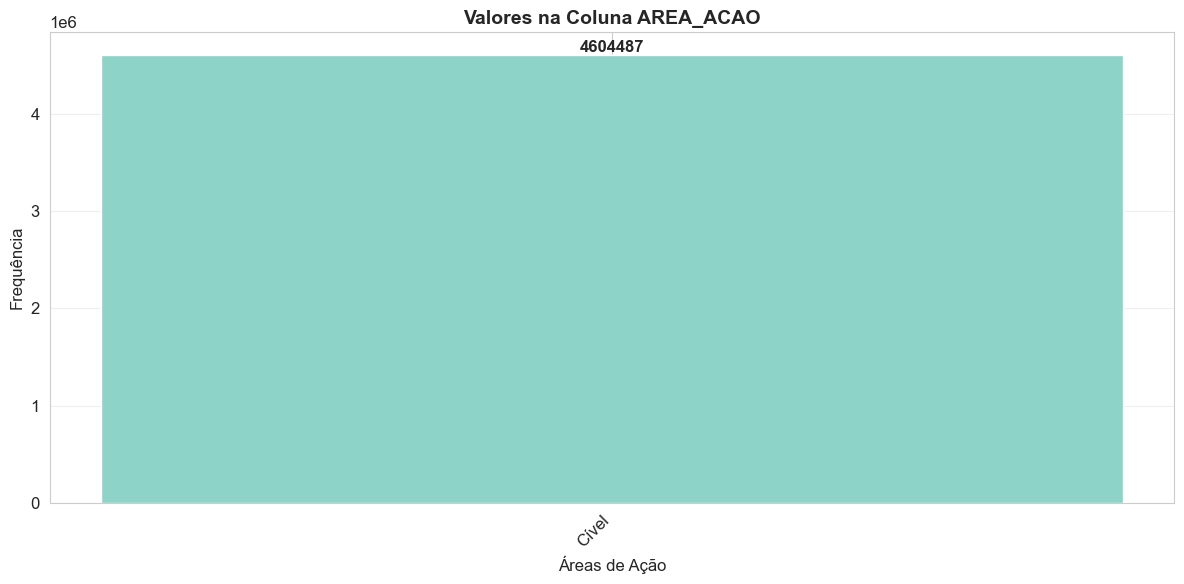

,Área de Ação,Contagem,Percentual (%)
0,Cível,4604487,100.0



💡 Informações adicionais:
   • Tipo de dados: object
   • Valores nulos: 0
   • Valor mais frequente: Cível (4604487 ocorrências)

📅 VERIFICAÇÃO DA COLUNA DATA_RECEBIMENTO
Tipo atual da coluna: object
Exemplo de valores: ['2020-09-06', '2020-09-06', '2020-09-06']
✅ Nenhum valor nulo na coluna DATA_RECEBIMENTO


In [16]:
print("🔍 CONTAGEM DE VALORES AUSENTES POR COLUNA")
print("=" * 50)

missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# Criar DataFrame para melhor visualização
missing_df = pd.DataFrame({
    'Valores Ausentes': missing_values, 
    'Percentual (%)': missing_percentage.round(2)
})

# Exibir apenas colunas com valores ausentes
missing_data = missing_df[missing_df['Valores Ausentes'] > 0].sort_values(by='Valores Ausentes', ascending=False)

if not missing_data.empty:
    # Formatar manualmente sem usar .style
    print("Tabela 1: Valores Ausentes no Dataset")
    print("-" * 50)
    
    for idx, row in missing_data.iterrows():
        percent = row['Percentual (%)']
        if percent > 10:
            color_code = "\033[91m"  # Vermelho
        elif percent > 5:
            color_code = "\033[93m"  # Amarelo
        else:
            color_code = "\033[33m"  # Laranja
        
        reset_code = "\033[0m"
        print(f"{idx:<20} | {row['Valores Ausentes']:<16} | {color_code}{percent:.2f}%{reset_code}")
    
    print("-" * 50)
else:
    print("✅ Nenhum valor ausente encontrado no dataset!")

# 2.2. Verificação de registros duplicados
print("\n" + "=" * 60)
num_duplicates = df.duplicated().sum()
if num_duplicates > 0:
    print(f"⚠️  ALERTA: {num_duplicates} linhas completamente duplicadas encontradas!")
else:
    print("✅ Nenhum registro duplicado encontrado!")

# 2.3. Investigação inicial da coluna AREA_ACAO
print("\n" + "=" * 60)
print("🔎 INVESTIGAÇÃO DA COLUNA 'AREA_ACAO'")

if 'AREA_ACAO' in df.columns:
    # Verificar valores únicos
    unique_areas = df['AREA_ACAO'].nunique()
    print(f"Número de valores únicos na coluna AREA_ACAO: {unique_areas}")
    
    # Mostrar distribuição dos valores
    print("\nDistribuição dos valores")
    area_distribution = df['AREA_ACAO'].value_counts().head(10)
    
    # Criar gráfico de barras com cores diferentes para cada área
    plt.figure(figsize=(12, 6))
    
    # Definir uma paleta de cores distintas para cada barra
    colors = plt.cm.Set3(np.linspace(0, 1, len(area_distribution)))
    
    bars = plt.bar(range(len(area_distribution)), area_distribution.values, color=colors)
    plt.title('Valores na Coluna AREA_ACAO', fontsize=14, fontweight='bold')
    plt.xlabel('Áreas de Ação', fontsize=12)
    plt.ylabel('Frequência', fontsize=12)
    
    # Adicionar os valores nas barras
    for i, (bar, count) in enumerate(zip(bars, area_distribution.values)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                str(count), ha='center', va='bottom', fontweight='bold')
    
    # Rotacionar labels para melhor visualização
    plt.xticks(range(len(area_distribution)), area_distribution.index, rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    # Exibir tabela com valores e porcentagens
    display(HTML("<h4 style='color: #2E86AB;'>📊 Distribuição da Área de Ação </h4>"))
    
    area_table = pd.DataFrame({
        'Área de Ação': area_distribution.index,
        'Contagem': area_distribution.values,
        'Percentual (%)': (area_distribution.values / len(df) * 100).round(2)
    })
    
    display(area_table)
    
    # Informações adicionais sobre a coluna
    print(f"\n💡 Informações adicionais:")
    print(f"   • Tipo de dados: {df['AREA_ACAO'].dtype}")
    print(f"   • Valores nulos: {df['AREA_ACAO'].isnull().sum()}")
    print(f"   • Valor mais frequente: {area_distribution.index[0]} ({area_distribution.values[0]} ocorrências)")
    
else:
    print("❌ Coluna 'AREA_ACAO' não encontrada no DataFrame")

# Verificar tipo da coluna DATA_RECEBIMENTO
print("\n" + "=" * 60)
print("📅 VERIFICAÇÃO DA COLUNA DATA_RECEBIMENTO")
if 'DATA_RECEBIMENTO' in df.columns:
    print(f"Tipo atual da coluna: {df['DATA_RECEBIMENTO'].dtype}")
    print(f"Exemplo de valores: {df['DATA_RECEBIMENTO'].head(3).tolist()}")
    
    # Verificar se há valores nulos nesta coluna específica
    null_count = df['DATA_RECEBIMENTO'].isnull().sum()
    if null_count > 0:
        print(f"⚠️  ALERTA: {null_count} valores nulos encontrados na coluna DATA_RECEBIMENTO")
    else:
        print("✅ Nenhum valor nulo na coluna DATA_RECEBIMENTO")
        
else:
    print("Coluna 'DATA_RECEBIMENTO' não encontrada")

In [18]:
df.describe(include='all')
# 3.1. Verificação de valores extremos (outliers)

,NUMERO,ASSUNTOS,DATA_RECEBIMENTO,PRIORIDADE,SEGREDO_JUSTICA,SERVENTIA,COMARCA,CLASSE,PROC_STATUS,AREA_ACAO,VALOR_CAUSA,CNJ_ASSUNTO,PROJUDI_ASSUNTO
count,4604487,4604487,4604487,4604487,0.0,4604487,4604487,4.604083e+06,4604487,4604487,4.603370e+06,4604487,4604487
unique,4604487,48556,3646,22,NaN,1406,119,NaN,7,1,NaN,44593,48556
top,-245875-70.2020.8.09.0000,5952,2014-09-22,Normal,NaN,Goiânia - 2ª UPJ Juizados Especiais Cíveis: 6º...,GOIÂNIA,NaN,Arquivado,Cível,NaN,['IPTU/ Imposto Predial e Territorial Urbano'],['DIREITO TRIBUTÁRIO -> Impostos -> IPTU/ Impo...
freq,1,465534,7391,3823632,NaN,249361,1708693,NaN,4141244,4604487,NaN,465534,465534
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.200850e+03,NaN,NaN,5.337480e+18,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.081212e+03,NaN,NaN,1.145178e+22,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.000000e+00,NaN,NaN,-6.800000e+06,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.560000e+02,NaN,NaN,1.076000e+04,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.360000e+02,NaN,NaN,6.302000e+04,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.389000e+03,NaN,NaN,2.084100e+05,NaN,NaN


🚀 INICIANDO ANÁLISE DE SEGMENTOS

🎯 ============================================================
📈 ANÁLISE DA COLUNA: 'COMARCA
🎯 ============================================================
🔢 Número de categorias únicas: 119
📊 As 15 categorias principais representam 70.26% de todos os casos.


C:\Users\mlzengo\AppData\Local\Temp\ipykernel_12836\66968218.py:77: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


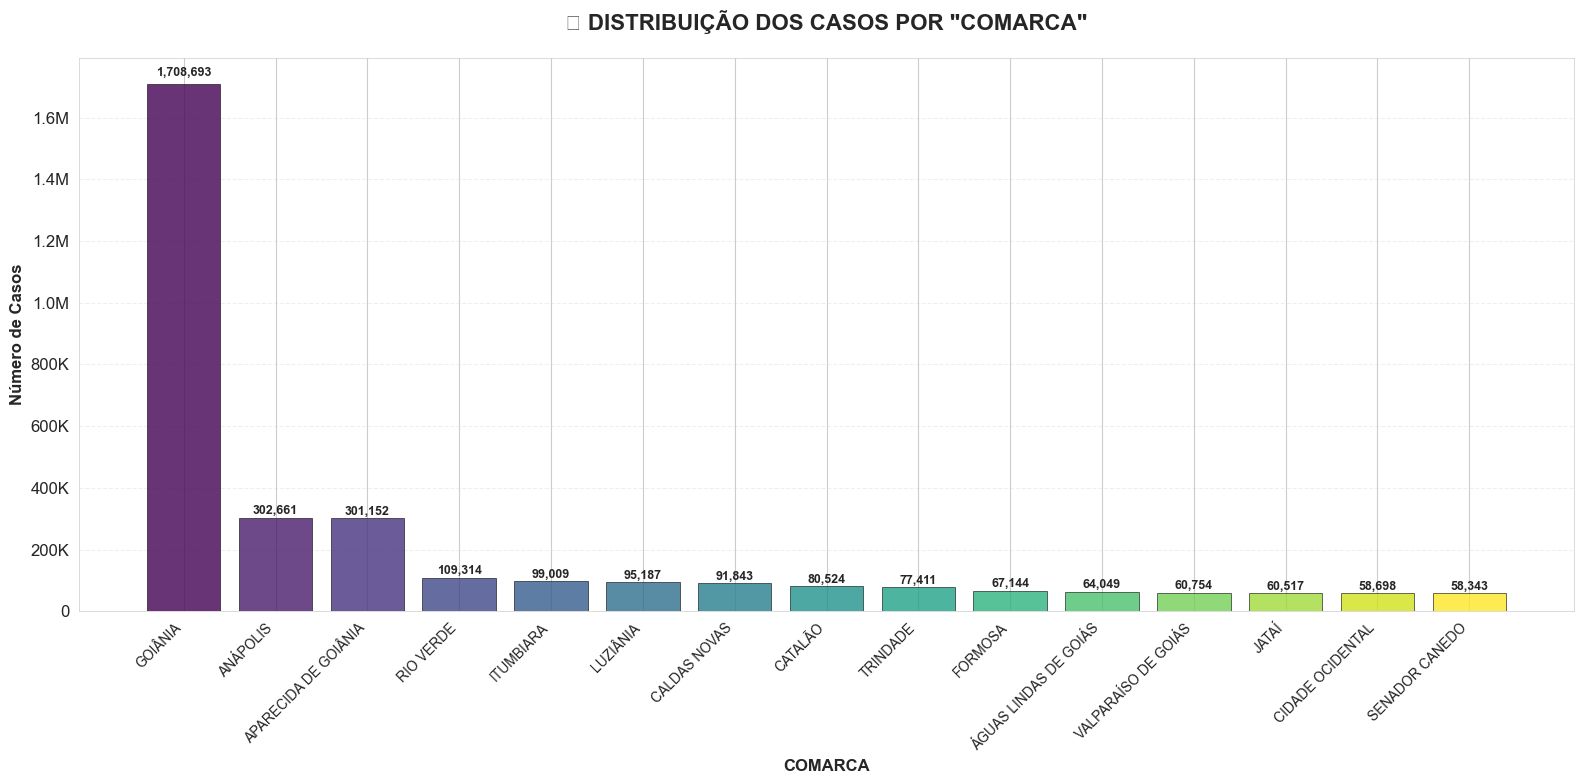

,Categoria,Contagem,Percentual (%)
0,GOIÂNIA,1708693,37.11
1,ANÁPOLIS,302661,6.57
2,APARECIDA DE GOIÂNIA,301152,6.54
3,RIO VERDE,109314,2.37
4,ITUMBIARA,99009,2.15
5,LUZIÂNIA,95187,2.07
6,CALDAS NOVAS,91843,1.99
7,CATALÃO,80524,1.75
8,TRINDADE,77411,1.68
9,FORMOSA,67144,1.46



💡 RESUMO ESTATÍSTICO:
   • Categoria mais frequente: 'GOIÂNIA' (1,708,693 casos)
   • Representatividade da categoria principal: 37.11%

📋 LISTA DE COLUNAS CATEGÓRICAS DISPONÍVEIS PARA ANÁLISE:
1. PRIORIDADE
2. SEGREDO_JUSTICA
3. SERVENTIA
4. CLASSE
5. ASSUNTOS
6. PROC_STATUS
7. AREA_ACAO


In [16]:
def analisar_segmento(df, coluna, top_n=15):
    """
    📊 Função para analisar e visualizar a distribuição de uma coluna categórica.
    
    Parâmetros:
    -----------
    df : DataFrame
        DataFrame contendo os dados
    coluna : str
        Nome da coluna categórica a ser analisada
    top_n : int, opcional (padrão=15)
        Número de categorias principais a serem visualizadas
    """
    print(f"\n🎯 {'='*60}")
    print(f"📈 ANÁLISE DA COLUNA: '{coluna.upper()}")
    print(f"🎯 {'='*60}")
    
    # Verificar se a coluna existe
    if coluna not in df.columns:
        print(f"❌ ERRO: Coluna '{coluna}' não encontrada no DataFrame!")
        return None
    
    # Quantidade de valores únicos
    num_unicos = df[coluna].nunique()
    print(f"🔢 Número de categorias únicas: {num_unicos}")
    
    # Verificar valores nulos
    nulos = df[coluna].isnull().sum()
    if nulos > 0:
        print(f"⚠️  Valores nulos: {nulos} ({nulos/len(df)*100:.2f}%)")
    
    # Contagem das categorias mais frequentes
    contagem = df[coluna].value_counts()
    
    # Porcentagem do total representada pelas Top N categorias
    porc_top_n = (contagem.head(top_n).sum() / len(df)) * 100
    print(f"📊 As {top_n} categorias principais representam {porc_top_n:.2f}% de todos os casos.")
    
    # Visualização com estilo aprimorado
    plt.figure(figsize=(16, 8))
    
    # Criar paleta de cores vibrantes
    cores = plt.cm.viridis(np.linspace(0, 1, top_n))
    
    # Criar gráfico de barras
    bars = plt.bar(range(top_n), contagem.head(top_n).values, color=cores, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Personalizar título e rótulos
    plt.title(f'📋 DISTRIBUIÇÃO DOS CASOS POR "{coluna.upper()}"', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Número de Casos', fontsize=12, fontweight='bold')
    plt.xlabel(coluna, fontsize=12, fontweight='bold')
    
    # Rotacionar labels para melhor visualização
    plt.xticks(range(top_n), contagem.head(top_n).index, rotation=45, ha='right', fontsize=10)
    
    # Adicionar valores nas barras
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Adicionar grid para melhor legibilidade
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Formatar eixo Y para valores grandes
    def formatar_valores(x, pos):
        if x >= 1_000_000:
            return f'{x/1_000_000:.1f}M'
        elif x >= 1_000:
            return f'{x/1_000:.0f}K'
        else:
            return f'{int(x)}'
    
    plt.gca().yaxis.set_major_formatter(FuncFormatter(formatar_valores))
    
    # Ajustar layout
    plt.tight_layout()
    
    # Adicionar borda ao gráfico
    for spine in plt.gca().spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.5)
    
    plt.show()
    
    # Exibir tabela com as top categorias
    display(HTML(f"<h4 style='color: #2E86AB;'>📋 TOP {top_n} CATEGORIAS - {coluna.upper()}</h4>"))
    
    tabela_resultados = pd.DataFrame({
        'Categoria': contagem.head(top_n).index,
        'Contagem': contagem.head(top_n).values,
        'Percentual (%)': (contagem.head(top_n).values / len(df) * 100).round(2)
    })
    
    display(tabela_resultados)
    
    print(f"\n💡 RESUMO ESTATÍSTICO:")
    print(f"   • Categoria mais frequente: '{contagem.index[0]}' ({contagem.values[0]:,} casos)")
    print(f"   • Representatividade da categoria principal: {contagem.values[0]/len(df)*100:.2f}%")
    
    return contagem

# Exemplo de uso com estilo
print("🚀 INICIANDO ANÁLISE DE SEGMENTOS")
print("=" * 60)

contagem_comarca = analisar_segmento(df, 'COMARCA')

# Análise adicional para outras colunas categóricas
colunas_interesse = ['PRIORIDADE', 'SEGREDO_JUSTICA', 'SERVENTIA', 'CLASSE', 'ASSUNTOS', 'PROC_STATUS', 'AREA_ACAO']

print(f"\n{'='*60}")
print("📋 LISTA DE COLUNAS CATEGÓRICAS DISPONÍVEIS PARA ANÁLISE:")
print("=" * 60)

for i, coluna in enumerate(colunas_interesse, 1):
    if coluna in df.columns:
        print(f"{i}. {coluna}")
    else:
        print(f"{i}. {coluna} ❌ (não encontrada)")
        

🚀 INICIANDO ANÁLISE DE SEGMENTOS

🎯 ============================================================
📈 ANÁLISE DA COLUNA SIMPLES: 'CLASSE'
🎯 ============================================================
🔢 Número de categorias únicas: 351
⚠️  Valores nulos: 404 (0.01%)
📊 As 20 categorias principais representam 90.65% de todos os casos.


C:\Users\mlzengo\AppData\Local\Temp\ipykernel_12836\3712673440.py:46: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


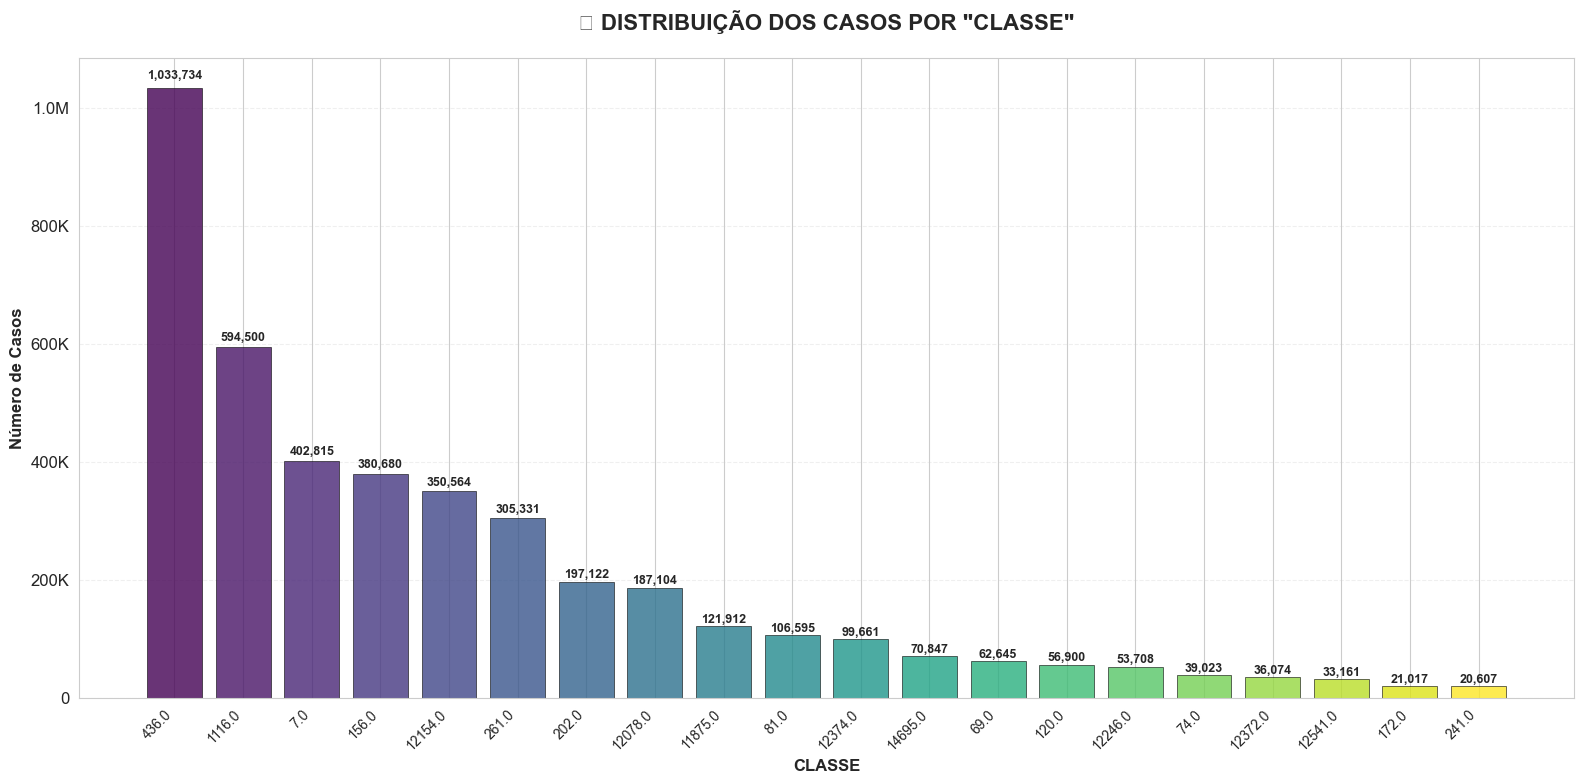

,Categoria,Contagem,Percentual (%)
0,436.0,1033734,22.45
1,1116.0,594500,12.91
2,7.0,402815,8.75
3,156.0,380680,8.27
4,12154.0,350564,7.61
5,261.0,305331,6.63
6,202.0,197122,4.28
7,12078.0,187104,4.06
8,11875.0,121912,2.65
9,81.0,106595,2.32



💡 RESUMO ESTATÍSTICO:
   • Categoria mais frequente: '436.0' (1,033,734 casos)
   • Representatividade da categoria principal: 22.45%

🎯 ============================================================
📈 ANÁLISE DA COLUNA DE LISTAS: 'ASSUNTOS'
🎯 ============================================================
🔢 Número de itens únicos: 48556
📊 Os 20 itens principais representam 47.14% de todas as ocorrências de itens.


C:\Users\mlzengo\AppData\Local\Temp\ipykernel_12836\3712673440.py:105: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


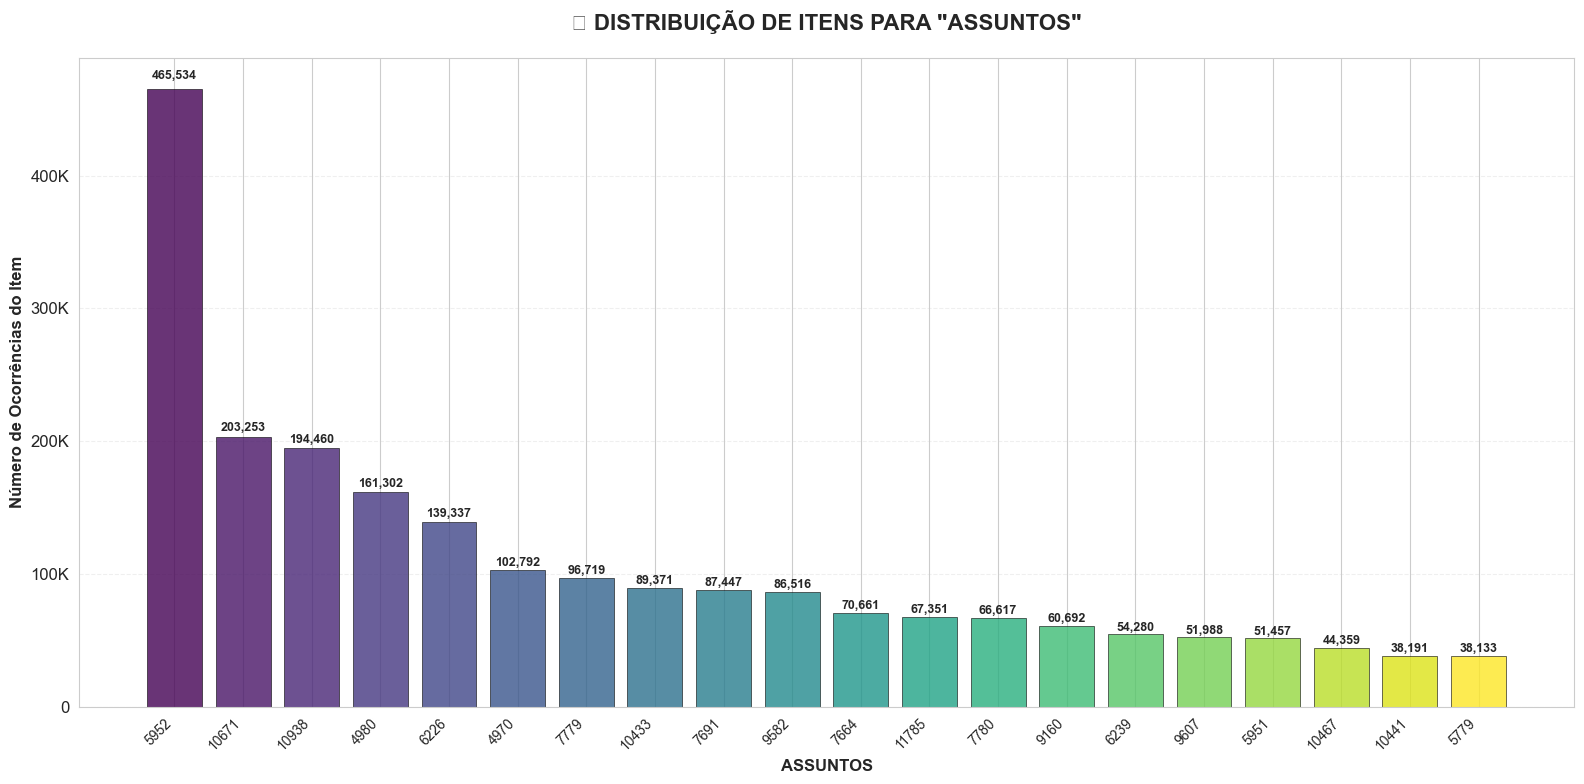

,Item,Contagem,Percentual (%)
0,5952,465534,10.11
1,10671,203253,4.41
2,10938,194460,4.22
3,4980,161302,3.50
4,6226,139337,3.03
5,4970,102792,2.23
6,7779,96719,2.10
7,10433,89371,1.94
8,7691,87447,1.90
9,9582,86516,1.88



💡 RESUMO ESTATÍSTICO:
   • Item mais frequente: '5952' (465,534 ocorrências)
   • Representatividade do item principal: 10.11%

🎯 ============================================================
📈 ANÁLISE DA COLUNA DE LISTAS: 'CNJ_ASSUNTO'
🎯 ============================================================
🔢 Número de itens únicos: 44593
📊 Os 20 itens principais representam 50.56% de todas as ocorrências de itens.


C:\Users\mlzengo\AppData\Local\Temp\ipykernel_12836\3712673440.py:105: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


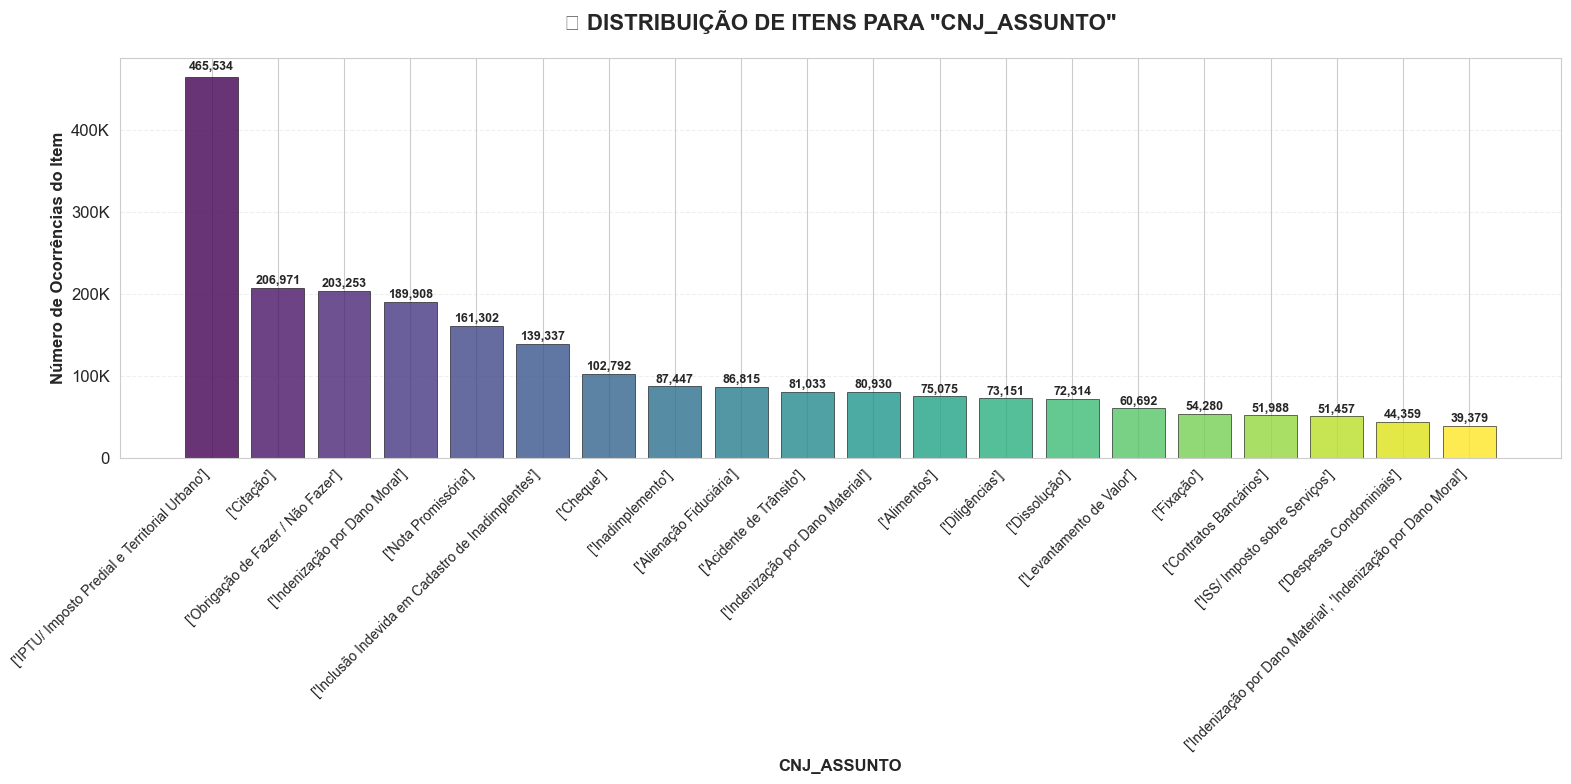

,Item,Contagem,Percentual (%)
0,['IPTU/ Imposto Predial e Territorial Urbano'],465534,10.11
1,['Citação'],206971,4.49
2,['Obrigação de Fazer / Não Fazer'],203253,4.41
3,['Indenização por Dano Moral'],189908,4.12
4,['Nota Promissória'],161302,3.50
5,['Inclusão Indevida em Cadastro de Inadimplent...,139337,3.03
6,['Cheque'],102792,2.23
7,['Inadimplemento'],87447,1.90
8,['Alienação Fiduciária'],86815,1.89
9,['Acidente de Trânsito'],81033,1.76



💡 RESUMO ESTATÍSTICO:
   • Item mais frequente: '['IPTU/ Imposto Predial e Territorial Urbano']' (465,534 ocorrências)
   • Representatividade do item principal: 10.11%


In [17]:


# --- FUNÇÃO PARA COLUNAS CATEGÓRICAS SIMPLES (Inalterada) ---
def analisar_segmento_simples(df, coluna, top_n=30):
    # (Seu código original para colunas simples vai aqui, sem nenhuma alteração)
    print(f"\n🎯 {'='*60}")
    print(f"📈 ANÁLISE DA COLUNA SIMPLES: '{coluna.upper()}'")
    print(f"🎯 {'='*60}")
    
    if coluna not in df.columns:
        print(f"❌ ERRO: Coluna '{coluna}' não encontrada no DataFrame!")
        return None
    
    num_unicos = df[coluna].nunique()
    print(f"🔢 Número de categorias únicas: {num_unicos}")
    
    # ... (o resto da sua função continua igual)
    nulos = df[coluna].isnull().sum()
    if nulos > 0:
        print(f"⚠️  Valores nulos: {nulos} ({nulos/len(df)*100:.2f}%)")
    
    contagem = df[coluna].value_counts()
    porc_top_n = (contagem.head(top_n).sum() / len(df)) * 100
    print(f"📊 As {top_n} categorias principais representam {porc_top_n:.2f}% de todos os casos.")
    
    plt.figure(figsize=(16, 8))
    cores = plt.cm.viridis(np.linspace(0, 1, top_n))
    bars = plt.bar(range(top_n), contagem.head(top_n).values, color=cores, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    plt.title(f'📋 DISTRIBUIÇÃO DOS CASOS POR "{coluna.upper()}"', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Número de Casos', fontsize=12, fontweight='bold')
    plt.xlabel(coluna, fontsize=12, fontweight='bold')
    plt.xticks(range(top_n), contagem.head(top_n).index, rotation=45, ha='right', fontsize=10)
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                 f'{height:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    def formatar_valores(x, pos):
        if x >= 1_000_000: return f'{x/1_000_000:.1f}M'
        elif x >= 1_000: return f'{x/1_000:.0f}K'
        else: return f'{int(x)}'
    
    plt.gca().yaxis.set_major_formatter(FuncFormatter(formatar_valores))
    plt.tight_layout()
    plt.show()
    
    display(HTML(f"<h4 style='color: #2E86AB;'>📋 TOP {top_n} CATEGORIAS - {coluna.upper()}</h4>"))
    tabela_resultados = pd.DataFrame({
        'Categoria': contagem.head(top_n).index,
        'Contagem': contagem.head(top_n).values,
        'Percentual (%)': (contagem.head(top_n).values / len(df) * 100).round(2)
    })
    display(tabela_resultados)
    
    print(f"\n💡 RESUMO ESTATÍSTICO:")
    print(f"   • Categoria mais frequente: '{contagem.index[0]}' ({contagem.values[0]:,} casos)")
    print(f"   • Representatividade da categoria principal: {contagem.values[0]/len(df)*100:.2f}%")
    return contagem

# --- NOVA FUNÇÃO PARA COLUNAS COM LISTAS (Inalterada) ---
def analisar_segmento_lista(df, coluna, top_n=30):
    # (A função que usa .explode() continua igual à anterior)
    print(f"\n🎯 {'='*60}")
    print(f"📈 ANÁLISE DA COLUNA DE LISTAS: '{coluna.upper()}'")
    print(f"🎯 {'='*60}")
    
    if coluna not in df.columns:
        print(f"❌ ERRO: Coluna '{coluna}' não encontrada no DataFrame!")
        return None
    
    exploded_series = df[coluna].explode().dropna()
    
    num_unicos = exploded_series.nunique()
    print(f"🔢 Número de itens únicos: {num_unicos}")
    
    # ... (o resto da função continua igual)
    contagem = exploded_series.value_counts()
    porc_top_n = (contagem.head(top_n).sum() / len(exploded_series)) * 100
    print(f"📊 Os {top_n} itens principais representam {porc_top_n:.2f}% de todas as ocorrências de itens.")
    
    plt.figure(figsize=(16, 8))
    cores = plt.cm.viridis(np.linspace(0, 1, top_n))
    bars = plt.bar(range(top_n), contagem.head(top_n).values, color=cores, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    plt.title(f'📋 DISTRIBUIÇÃO DE ITENS PARA "{coluna.upper()}"', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Número de Ocorrências do Item', fontsize=12, fontweight='bold')
    plt.xlabel(coluna, fontsize=12, fontweight='bold')
    plt.xticks(range(top_n), contagem.head(top_n).index, rotation=45, ha='right', fontsize=10)
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                 f'{height:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    def formatar_valores(x, pos):
        if x >= 1_000_000: return f'{x/1_000_000:.1f}M'
        elif x >= 1_000: return f'{x/1_000:.0f}K'
        else: return f'{int(x)}'
        
    plt.gca().yaxis.set_major_formatter(FuncFormatter(formatar_valores))
    plt.tight_layout()
    plt.show()
    
    display(HTML(f"<h4 style='color: #2E86AB;'>📋 TOP {top_n} ITENS - {coluna.upper()}</h4>"))
    tabela_resultados = pd.DataFrame({
        'Item': contagem.head(top_n).index,
        'Contagem': contagem.head(top_n).values,
        'Percentual (%)': (contagem.head(top_n).values / len(exploded_series) * 100).round(2)
    })
    display(tabela_resultados)

    print(f"\n💡 RESUMO ESTATÍSTICO:")
    print(f"   • Item mais frequente: '{contagem.index[0]}' ({contagem.values[0]:,} ocorrências)")
    print(f"   • Representatividade do item principal: {contagem.values[0]/len(exploded_series)*100:.2f}%")
    return contagem

# --- FUNÇÃO PRINCIPAL CORRIGIDA E MAIS ROBUSTA ---
def analisar_coluna(df, coluna, top_n=30):
    """
    Analisa uma coluna do DataFrame, decidindo qual função usar
    com base em uma lista explícita de colunas que contêm listas.
    """
    # Lista explícita das colunas que sabemos que contêm listas
    COLUNAS_DE_LISTAS = ['ASSUNTOS', 'CNJ_ASSUNTO', 'PROJUDI_ASSUNTO']
    
    if coluna in COLUNAS_DE_LISTAS:
        # Se a coluna estiver na nossa lista, usa a função para listas
        analisar_segmento_lista(df, coluna, top_n)
    else:
        # Caso contrário, usa a função para categorias simples
        analisar_segmento_simples(df, coluna, top_n)


# ==============================================================================
# --- EXEMPLO DE USO ---
# Agora as chamadas funcionarão corretamente para ambos os casos
# ==============================================================================

print("🚀 INICIANDO ANÁLISE DE SEGMENTOS")
print("=" * 60)

# 1. Análise de uma coluna categórica SIMPLES
analisar_coluna(df, 'CLASSE', top_n=20)

# 2. Análise de uma coluna com LISTAS
analisar_coluna(df, 'ASSUNTOS', top_n=20)

# 3. Análise de outra coluna com LISTAS
analisar_coluna(df, 'CNJ_ASSUNTO', top_n=20)